# Utilizing Machine Learning to Detect Flight Delays
<a id="top"></a>
### **Research Question**
How accurately can flight delays be predicted using airline performance data and weather data?

### **Project Outline**
1.	**Import and Clean Data:** Two datasets consisting of airline performance data and weather data.
2.	**PostgreSQL Database:** Create a database from the cleaned datasets and then query database for finalized project dataset.
3.	**Exploratory Data Analysis**
4.	**Machine Learning:** Train the following models with default parameters. Select optimal model based on accuracy score.
 + Logistic Regression Classifier
 + Gradient Boosting Classifier
 + Random Forest Classifier
 + Support Vector Classifier 
5.	**Principal Component Analysis:** Conduct PCA and train optimal model on reduced dataset.
6.	**Hypterparamer Tuning:** Use GridSearch to tune optimal model.
7.	**Conclusion:** Evaluate baseline, tuned, post_PCA, and tuned + post_pca performance for the optimal model.

### **Project Scope**

**Dataset:** Balanced  
**# of Records:** ~100,000  
**Accuracy Metric:** Accuracy score  

**Year:** 2019  
**Airline:** Delta  
**Origin Airports:**
* Atlanta (ATL)
* Detroit (DTW)
* LaGuardia (LGA) 
* Minneapolis/St. Paul (MSP)
* Salt Lake City (SLC)

### **Data Sources**
1.	**Airline On-Time Performance data:** <a href="https://www.transtats.bts.gov/DL_SelectFields.asp?gnoyr_VQ=FGK">Bureau of Transportation Statistics (BTS)</a>
2.	**Hourly local climatological (weather) data:** <a href="https://www.ncdc.noaa.gov/cdo-web/datatools/lcd">National Oceanic and Atmospheric Administration (NOAA).</a>

# Imports    

In [1]:
# Imports & Database Connection

# Necessary imports for EDA & 'The Basics'
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math

# Necessary imports to connect to Postgresql
import sqlalchemy as db
import os
from dotenv import load_dotenv 
from sqlalchemy import create_engine

# Necessary imports for ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import metrics   

# Necessary imports for PCA
from sklearn.decomposition import PCA

# Load iPython-sql
%load_ext sql

# 1. DATAFRAMES: Create and Clean

## Airline Performance

In [2]:
# Enable display of all columns/rows for DataFrames

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Create DataFrame

# Load in all airline performance .csv files for 2019 and concat them into one large DataFrame
airline_months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
dataframes_list = []

for i in range(len(airline_months)):
    temp_df = pd.read_csv('AirlineData/' + airline_months[i] + '.csv')
    dataframes_list.append(temp_df)
    
airline_df = pd.concat(dataframes_list)

In [4]:
# Clean DataFrame

# DL = Delta Airlines

# ATL = Atlanta, Ga
# DTW = Detroit, MI
# LGA = LaGuardia, NY
# MSP = Minneapolis/St. Paul MN
# SLC = Salt Lake City, UT

airlines_keep = 'DL'
airports_keep = ['ATL', 'DTW', 'LGA', 'MSP', 'SLC']

# filter for Delta Airlines and top 5 origin airports.
airline_df = airline_df[airline_df['MKT_UNIQUE_CARRIER'] == airlines_keep]
airline_df = airline_df[airline_df['ORIGIN'].isin(airports_keep)]

# convert FL_DATE to datetime object
airline_df['FL_DATE'] =  pd.to_datetime(airline_df['FL_DATE'])

# extract scheduled departure hour and rename column
airline_df['CRS_DEP_TIME'] = airline_df['CRS_DEP_TIME']//100
airline_df = airline_df.rename(columns = {'CRS_DEP_TIME' : 'CRS_DEP_HR'})

In [5]:
airline_df.head()

,DAY_OF_WEEK,FL_DATE,MKT_UNIQUE_CARRIER,MKT_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_HR,DEP_TIME,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
3550,1,2019-01-14,DL,7360,14869,SLC,"Salt Lake City, UT",13127,LWS,"Lewiston, ID",11,1059.0,0.0,-1.0,1100-1159,1158,1153.0,0.0,-1.0,1100-1159,113.0,114.0,71.0,1,461,2,NaN,NaN,NaN,NaN,NaN
3552,1,2019-01-14,DL,7361,14869,SLC,"Salt Lake City, UT",14113,PIH,"Pocatello, ID",11,1159.0,1.0,3.0,1100-1159,1215,1242.0,1.0,1.0,1200-1259,65.0,43.0,28.0,1,150,1,27.0,0.0,0.0,0.0,0.0
3555,1,2019-01-14,DL,7363,13487,MSP,"Minneapolis, MN",10141,ABR,"Aberdeen, SD",11,1119.0,0.0,-1.0,1100-1159,1255,1255.0,0.0,0.0,1200-1259,91.0,96.0,43.0,1,257,2,NaN,NaN,NaN,NaN,NaN
3559,1,2019-01-14,DL,7367,11433,DTW,"Detroit, MI",10333,APN,"Alpena, MI",12,1202.0,0.0,-1.0,1200-1259,1335,1305.0,0.0,-2.0,1300-1359,81.0,63.0,43.0,1,198,1,NaN,NaN,NaN,NaN,NaN
3564,1,2019-01-14,DL,7371,13487,MSP,"Minneapolis, MN",10631,BJI,"Bemidji, MN",11,1127.0,0.0,-1.0,1100-1159,1254,1216.0,0.0,-2.0,1200-1259,84.0,49.0,35.0,1,199,1,NaN,NaN,NaN,NaN,NaN



## Weather

In [6]:
# create DataFrame

# specify columns to keep from raw input file
weather_keep = ['STATION', 'DATE', 'REPORT_TYPE', 'HourlyAltimeterSetting', 'HourlyDewPointTemperature', 
                'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyRelativeHumidity', 
                'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature', 
                'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed']

wdf = pd.read_csv('AirlineData/weather.csv', usecols = weather_keep, low_memory = False)

In [7]:
# clean DataFrame

# some columns contain mixed data types (floats and floats with alpha characters. ie - 1.5, and 1.5s)
# records with alpha characters in the columns listed below are outlier records and will be removed.
spec_char_list = ['HourlyAltimeterSetting', 'HourlyDewPointTemperature', 
                'HourlyDryBulbTemperature', 'HourlyPrecipitation', 
                'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 
                'HourlyWindDirection']

for i in spec_char_list:
    wdf = wdf[~wdf[i].str.contains(r'[sStTvV]', na = False)]

    
# filter for report type of 'FM-15'
wdf = wdf[wdf['REPORT_TYPE'] == 'FM-15']

# replace station ids with corresponding airport code.
wdf = wdf.replace({'STATION' : { 72503014732 : 'LGA', 72219013874 : 'ATL', 72537094847 : 'DTW', 
                                72572024127 : 'SLC', 72658014922 : 'MSP'}})


# separate date and time from 'DATE' column, format new date & time columns, extract hour from timestamp  
# 'DATE' column example: 2019-01-01T00:08:00

split_dt = wdf["DATE"].str.split("T", n = 1, expand = True)
  
# insert "CAL_DATE" and "HOUR" columns into wdf Data Frame
wdf["FLIGHT_DATE"]= split_dt[0]
wdf["HOUR"]= split_dt[1]
  
#  drop old "DATE" column
wdf.drop(columns =["DATE"], inplace = True)

# convert "CAL_DATE" and "HOUR" to datetime objects
# extract hour from scheduled flight time.

wdf['FLIGHT_DATE'] =  pd.to_datetime(wdf['FLIGHT_DATE'])
wdf['HOUR'] =  pd.to_datetime(wdf['HOUR'])
wdf['HOUR'] = wdf['HOUR'].dt.hour

In [8]:
wdf.head()

,STATION,REPORT_TYPE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,FLIGHT_DATE,HOUR
1,LGA,FM-15,29.75,46,47,0.06,97.0,29.75,29.72,4,47.0,0,NaN,0.0,2019-01-01,0
5,LGA,FM-15,29.68,48,50,0.02,93.0,29.68,29.65,4,49.0,200,NaN,5.0,2019-01-01,1
9,LGA,FM-15,29.62,52,54,0,93.0,29.62,29.59,3,53.0,250,NaN,15.0,2019-01-01,3
12,LGA,FM-15,29.59,52,55,0,90.0,29.59,29.56,5,53.0,250,25.0,15.0,2019-01-01,4
15,LGA,FM-15,29.62,53,57,0,87.0,29.62,29.59,10,55.0,260,NaN,11.0,2019-01-01,5


# 2. DATABASE   

## Export Cleaned DataFrames to .CSV Files for Database Creation

In [9]:
# Export DataFrames to .CSV files to be used in database creation
# Import DataFrames into a PostgreSQL database, with each DataFrame being its own table.

airline_df.to_csv(r'AirlineData/Cleaned_Airline_Performance_Data_2.csv', index = False)
wdf.to_csv(r'AirlineData\Cleaned_Weather_Data.csv_2', index = False)

## Connect to Database

In [10]:
# Connect to database w/ environmental variables
load_dotenv()
user = os.getenv('SQL_USER')
password = os.getenv('SQL_PASSWORD')
host = os.getenv('SQL_HOST')
db = os.getenv('SQL_DB')

conn_text = 'postgresql://{}:{}@{}/{}'.format(user,password,host,db)

%sql $conn_text
engine = create_engine(conn_text)

## Query Database to Obtain Finalized Dataset

In [11]:
# Query database for matching flight and weather records. Store results in a new DataFrame.
# Project scope was limited to ~110,000 records, as indicated by the limit quantity.

# Because the number of records in this dataset far exceeds the scope of this project, a balanced dataset can be queried.
# This query pulls 55,250 on-time flights and 55,250 delayed flights.

q = '''
WITH
    arr1 AS (SELECT * FROM (
        SELECT DISTINCT * FROM flights
        INNER JOIN weather 
        ON flights.origin = weather.airport
            AND flights.fl_date = weather.flight_date 
            AND flights.crs_dep_hr = weather.hour
        WHERE arr_del15 = 1) AS arrsub1
    ORDER BY RANDOM()
    LIMIT 55250),

    arr0 AS (SELECT * FROM (
        SELECT DISTINCT * FROM flights
        INNER JOIN weather 
        ON flights.origin = weather.airport
            AND flights.fl_date = weather.flight_date 
            AND flights.crs_dep_hr = weather.hour
        WHERE arr_del15 = 0) AS arrsub0
        ORDER BY RANDOM()
        LIMIT 55250)
    
SELECT * FROM arr1 UNION SELECT * FROM ARR0;
'''

df = pd.read_sql (q, engine)


In [12]:
df.head()

,day_of_week,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_del15,dep_delay_group,dep_time_blk,crs_arr_time,arr_time,arr_del15,arr_delay_group,arr_time_blk,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,crs_dep_hr,airport,station,flight_date,time,hour,report_type,hourlyaltimetersetting,hourlydewpointtemperature,hourlydrybulbtemperature,hourlyprecipitation,hourlyrelativehumidity,hourlysealevelpressure,hourlystationpressure,hourlyvisibility,hourlywetbulbtemperature,hourlywinddirection,hourlywindgustspeed,hourlywindspeed
0,1,2019-08-26,DL,2222,10397,ATL,"Atlanta, GA",12889,LAS,"Las Vegas, NV",1145,1158,0,0,1100-1159,1253,1258,0,0,1200-1259,248,240,221,1,1747,7,NaN,NaN,NaN,NaN,NaN,11,ATL,72219013874,2019-08-26,11:52:00,11,FM-15,30.06,64.0,74.0,0.0,71.0,30.03,28.96,10.0,68.0,100.0,NaN,8.0
1,4,2019-07-25,DL,2042,10397,ATL,"Atlanta, GA",14100,PHL,"Philadelphia, PA",2059,2059,0,0,2000-2059,2305,2241,0,-2,2300-2359,126,102,90,1,666,3,NaN,NaN,NaN,NaN,NaN,20,ATL,72219013874,2019-07-25,20:52:00,20,FM-15,30.15,57.0,78.0,0.0,48.0,30.12,29.05,10.0,65.0,90.0,NaN,6.0
2,5,2019-03-01,DL,505,14869,SLC,"Salt Lake City, UT",13487,MSP,"Minneapolis, MN",1528,1559,1,2,1500-1559,1900,2029,1,5,1900-1959,152,210,131,1,991,4,0.0,0.0,82.0,0.0,7.0,15,SLC,72572024127,2019-03-01,15:54:00,15,FM-15,29.95,24.0,49.0,0.0,38.0,29.92,25.65,10.0,38.0,360.0,NaN,11.0
3,2,2019-03-05,DL,6253,11433,DTW,"Detroit, MI",11537,ELM,"Elmira/Corning, NY",1350,1513,1,5,1300-1359,1459,1617,1,5,1400-1459,69,64,44,1,332,2,78.0,0.0,0.0,0.0,0.0,13,DTW,72537094847,2019-03-05,13:53:00,13,FM-15,29.99,6.0,19.0,0.0,57.0,30.03,29.28,3.0,16.0,260.0,24.0,15.0
4,4,2019-08-08,DL,5324,10397,ATL,"Atlanta, GA",14814,SHV,"Shreveport, LA",1933,1940,0,0,1900-1959,2025,2041,1,1,2000-2059,112,121,83,1,551,3,0.0,0.0,9.0,0.0,7.0,19,ATL,72219013874,2019-08-08,19:52:00,19,FM-15,29.95,69.0,84.0,0.0,61.0,29.91,28.85,10.0,74.0,300.0,NaN,7.0


In [13]:
df['arr_del15'].value_counts()

0    55250
1    55250
Name: arr_del15, dtype: int64

## Address NULL's and 0's

In [14]:
# Print out list of columns with NULL and "0" values

null_values = df.isna()
null_columns = null_values.any()
cols_with_null = df.columns[null_columns].tolist()

df_missing = pd.DataFrame({'NULL': df[cols_with_null].isnull().sum(),
                    'zeros': (df[cols_with_null] == 0).sum()})
df_missing

,NULL,zeros
carrier_delay,55250,26391
weather_delay,55250,51336
nas_delay,55250,26829
security_delay,55250,55171
late_aircraft_delay,55250,31489
hourlyaltimetersetting,38,0
hourlydewpointtemperature,43,161
hourlydrybulbtemperature,18,68
hourlyprecipitation,1584,98504
hourlyrelativehumidity,43,0


In [15]:
# Records with NULL values will be removed. Exception: records with NULL values in the columns listed in keep_null_cols. 
# NULL values in these columns mean "no dealys" or "no wind gusts", respectively.
keep_null_cols= ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'hourlywindgustspeed']

# Remove keep_null_cols from the list of columns containing NULL values
for i in keep_null_cols:
    cols_with_null.remove(i)
    
# Remove records with columns containing NULL
for i in cols_with_null:
    df = df[df[i].notnull()] 
    
# replace all remaining NULL values with zero's
df = df.fillna(0)

In [16]:
df['arr_del15'].value_counts()

0    54345
1    54165
Name: arr_del15, dtype: int64

# 3. EXPLORATORY DATA ANALYSIS

## Create Dataframes

In [17]:
# df will be used for EDA
# dfml will be used for the machine learning algorithms


dfml = df.drop(columns = ['mkt_unique_carrier', 'airport', 'station', 'flight_date', 'time', 'report_type',
                        'day_of_week', 'origin', 'origin_city_name', 'dest', 'dest_city_name', 'dep_time', 
                        'dep_del15', 'dep_delay_group', 'dep_time_blk', 'arr_time', 'arr_delay_group', 'arr_time_blk', 
                        'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights', 'distance', 'distance_group', 
                        'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'crs_dep_hr', 
                        'hour', 'fl_date'])

df = df.drop(columns = ['mkt_carrier_fl_num', 'mkt_unique_carrier', 'origin_airport_id', 'dest_airport_id', 
                        'airport', 'station', 'flight_date', 'time', 'hour', 'report_type'])

## Display EDA Plots

<ipython-input-18-35f552978314>:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels(['Unknown', '< -15' ,'-15 - -1', '0 - 14', '15 - 29', '30 - 44', '45 - 59', '60 - 74', '75 - 89'],


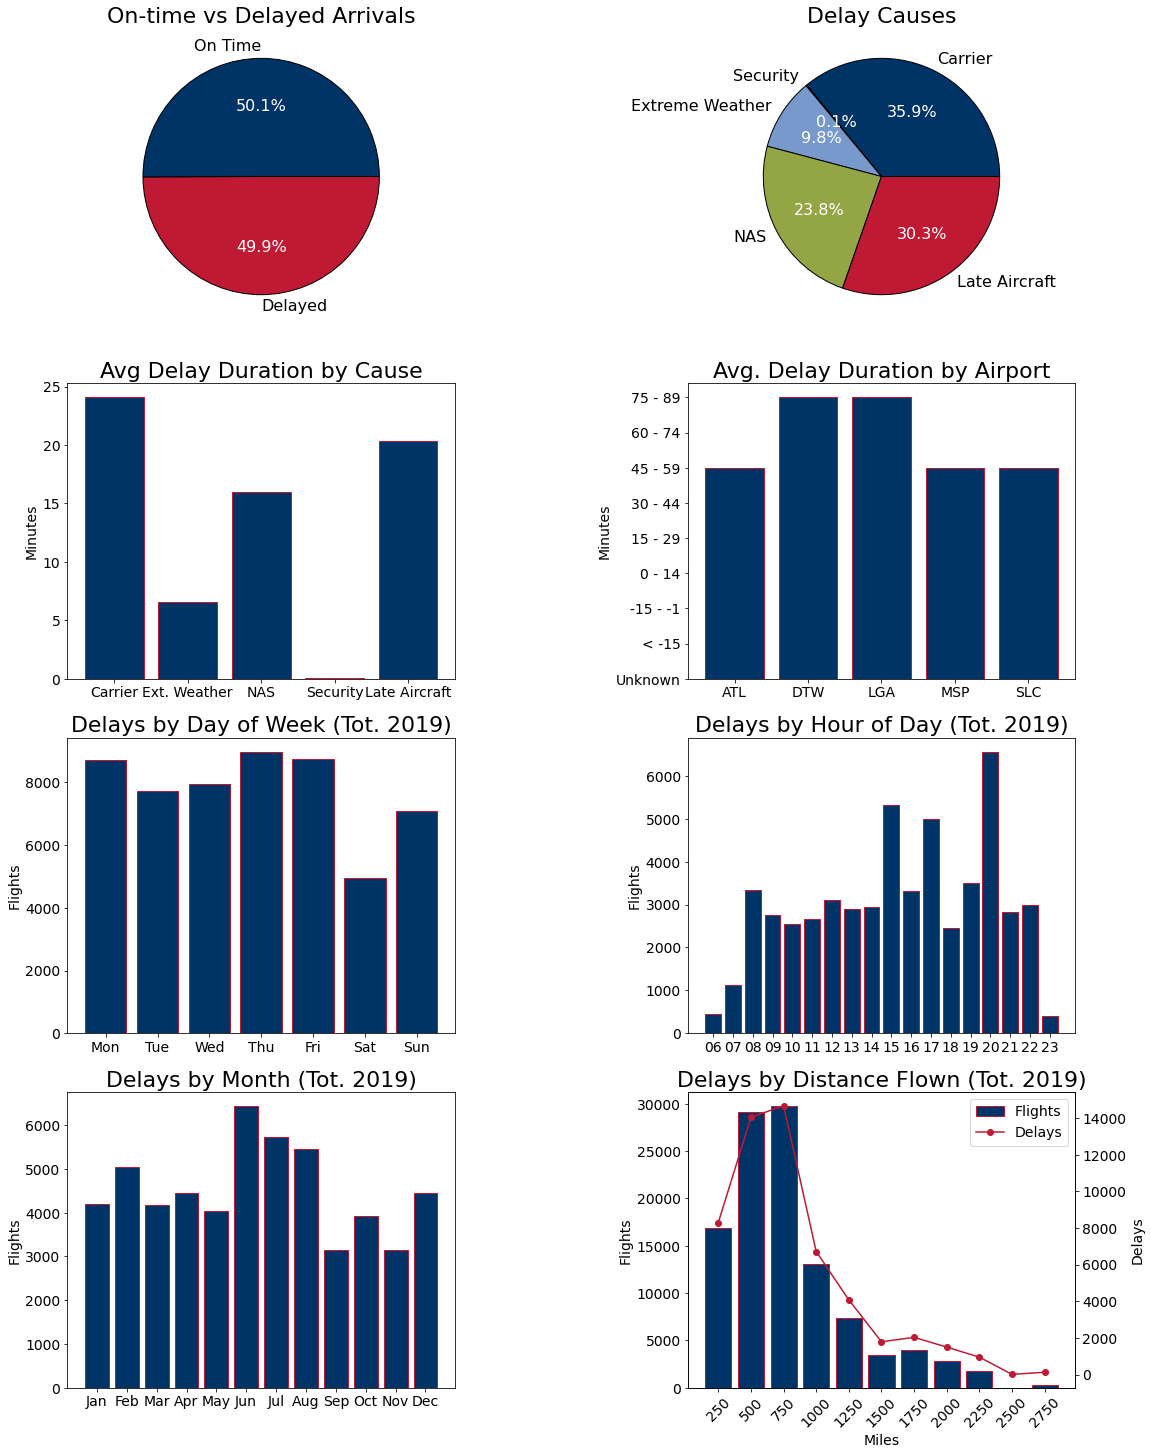

In [18]:
# 8 plots (AX1 - AX8), read from left to right, top to bottom.

# global plot settings
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20,25))
fig.subplots_adjust(left=0.2, wspace=0.6)
fontsize = 14




#### AX1 - On-time vs Delayed Arrivals Pie Chart ########################################

# data for pie chart
total_num_flights = df['flights'].sum() 
total_num_delayed_flights = df['arr_del15'].sum()
on_time = total_num_flights - total_num_delayed_flights

# plot pie chart
slices_plt_1 = [on_time, total_num_delayed_flights]
labels_plt_1 = ['On Time', 'Delayed']
colors_plt_1 = ['#003366', '#C01933']
patches, texts, pcts = ax1.pie(slices_plt_1, labels = labels_plt_1, colors = colors_plt_1, wedgeprops={'edgecolor': 'black'}, 
                               textprops={'size': 16}, autopct='%1.1f%%')
plt.setp(pcts, color='white')
ax1.set_title('On-time vs Delayed Arrivals', {'fontsize': 22})




#### AX2 - Delay Causes Pie Chart #######################################################

# sum up all delay durations, per delay category
cols_to_sum = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
summed_mins_delayed = df[cols_to_sum].sum()


# function to calculate prorated portions of delays =
# delay catgeory total minutes / all delays total minutes * total number of delayed flights 
def func(str):
    result = summed_mins_delayed[str]/summed_mins_delayed.sum()*total_num_delayed_flights.astype(int)
    return result

# assign results to repspective variables
carrier_delay_prorated = func('carrier_delay')
security_delay_prorated = func('security_delay')
weather_delay_prorated = func('weather_delay')
nas_delay_prorated = func('nas_delay')
late_aircraft_delay_prorated = func('late_aircraft_delay')

# plot pie chart
slices_plt_2 = [carrier_delay_prorated, security_delay_prorated, weather_delay_prorated, 
                nas_delay_prorated, late_aircraft_delay_prorated]
labels_plt_2 = ['Carrier', 'Security', 'Extreme Weather', 'NAS', 'Late Aircraft']
colors_plt_2 = ['#003366', '#EA8A1A', '#7799CC', '#94A545', '#C01933']
patches, texts, pcts = (ax2.pie(slices_plt_2, labels = labels_plt_2, colors = colors_plt_2, wedgeprops={'edgecolor': 'black'}, 
                               textprops={'size': 16}, autopct='%1.1f%%'))
plt.setp(pcts, color='white')
ax2.set_title('Delay Causes', {'fontsize': 22})




#### AX3 - Avg. Delay Duration by Cause Bar Chart ######################################

# calculate the average delay duration per category
df_delays_only = df[df['arr_del15'] == 1]
cols_to_mean = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
df_delayAvgs = df_delays_only[cols_to_mean].mean()

# plot bar chart
x_labels_plt_3 = ['Carrier', 'Ext. Weather', 'NAS', 'Security', 'Late Aircraft']
ax3.bar(x_labels_plt_3, height = df_delayAvgs, color = '#003366', edgecolor='#C01933')
ax3.set_title('Avg Delay Duration by Cause', {'fontsize': 22})
ax3.tick_params(axis='x', labelsize=fontsize)
ax3.tick_params(axis='y', labelsize=fontsize)
ax3.set_ylabel('Minutes', color="black", fontsize=fontsize)




#### AX4 -  Avg. Delay Duration by Airport Bar Chart ####################################

# calculate the average delay duration by airport
x_labels_plt_4 = ['ATL', 'DTW', 'LGA', 'MSP', 'SLC']
df_delays_only = df[df['arr_del15'] == 1]
df_delay_orig = df_delays_only.groupby(['origin'])['arr_delay_group'].mean().round(0).astype(int)

# plot bar chart
ax4.bar(x_labels_plt_4, height = df_delay_orig, color=('#003366'),  edgecolor='#C01933')
ax4.set_title('Avg. Delay Duration by Airport', {'fontsize': 22})
ax4.set_yticklabels(['Unknown', '< -15' ,'-15 - -1', '0 - 14', '15 - 29', '30 - 44', '45 - 59', '60 - 74', '75 - 89'], 
                    fontsize = 14)
ax4.set_ylabel('Minutes', color="black", fontsize=fontsize)
ax4.tick_params(axis='x', labelsize=fontsize)




#### AX5 - Delays by Day of Week Bar Chart #############################################

# gather number of delays by day of week
df_delay_by_day = df.groupby(['day_of_week'])[['arr_del15']].sum()

# plot bar chart
x_labels_plt_5 = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
y_labels_plt_5 = df_delay_by_day['arr_del15']
ax5.bar(x_labels_plt_5, y_labels_plt_5, color=('#003366'),  edgecolor='#C01933')
ax5.set_title('Delays by Day of Week (Tot. 2019)', {'fontsize': 22})
ax5.set_ylabel('Flights', color="black", fontsize=fontsize)
ax5.tick_params(axis='x', labelsize=fontsize)
ax5.tick_params(axis='y', labelsize=fontsize)




#### AX6 - Delays by Hour Bar Chart ###################################################

# gather number delays by crs_dep_hr (Computer Reservation System departure hour: hour when plane was scheduled to depart)
df_delay_by_hour = df.groupby(['crs_dep_hr'])[['arr_del15']].sum()

# resort the index to ascending hours; only plot hours with more than 30 delays to remove extreme outliers
df_delay_by_hour = df_delay_by_hour.sort_values(by = ['crs_dep_hr'], ascending = True)
df_delay_by_hour = df_delay_by_hour[df_delay_by_hour['arr_del15'] > 30]

# plot bar chart
x_labels_plt_6 = ['06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
y_labels_plt_6 = df_delay_by_hour['arr_del15']
ax6.set_title('Delays by Hour of Day (Tot. 2019)', {'fontsize': 22})
ax6.bar(x_labels_plt_6, y_labels_plt_6, color='#003366',  edgecolor='#C01933')
ax6.set_ylabel('Flights', color="black", fontsize=fontsize)
ax6.tick_params(axis='x', labelsize=fontsize)
ax6.tick_params(axis='y', labelsize=fontsize)




##### AX7 Delays by Month Bar Chart ##################################################

# gather number of flight delays by month
df['fl_date'] =  pd.to_datetime(df['fl_date'])
df['flight_month'] = df['fl_date'].dt.month
df_delay_by_month = df.groupby(['flight_month'])[['arr_del15']].sum()

# plot bar chart
x_labels_plt_7 = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
y_labels_plt_7 =  df_delay_by_month['arr_del15']
ax7.set_title('Delays by Month (Tot. 2019)', {'fontsize': 22})
ax7.bar(x_labels_plt_7, y_labels_plt_7, color=('#003366'),  edgecolor='#C01933')
ax7.set_ylabel('Flights', color="black", fontsize=fontsize)
ax7.tick_params(axis='x', labelsize=fontsize)
ax7.tick_params(axis='y', labelsize=fontsize)




#### AX8 - Delays by Distance Flown ##################################################

# gather number of flights, and delays by distance grouping
df_flights_by_distance = df.groupby(['distance_group'])[['flights']].sum()
df_delay_by_distance = df.groupby(['distance_group'])[['arr_del15', 'flights']].sum()

# plot 1st axis: number of flights per distance grouping
x_labels_plt_8 = ['250', '500', '750', '1000', '1250', '1500', '1750', '2000', '2250', '2500', '2750']
ax8.bar(x_labels_plt_8, df_flights_by_distance['flights'], color="#003366", edgecolor='#C01933', label = 'Flights')
ax8.set_xlabel("Miles", fontsize=fontsize)
ax8.set_ylabel("Flights",fontsize=fontsize)
ax8.tick_params(axis='y', labelsize=fontsize)
ax8.tick_params(axis='x', labelsize=fontsize, rotation = 45)

# plot 2nd axis: number of delays per distance grouping
ax8_second_axis = ax8.twinx()
ax8_second_axis.plot(x_labels_plt_8, df_delay_by_distance['arr_del15'], color='#C01933', marker = "o", label = 'Delays')
ax8_second_axis.set_title('Delays by Distance Flown (Tot. 2019)', {'fontsize': 22})
ax8_second_axis.set_ylabel('Delays', color="black", fontsize=fontsize)
ax8_second_axis.tick_params(axis='y', labelsize=fontsize)

# Legend
handles, labels = ax8.get_legend_handles_labels()
handles2, labels2 = ax8_second_axis.get_legend_handles_labels()
handles_combined = handles + handles2
labels_combined = labels +  labels2
ax8.legend(handles_combined, labels_combined, prop={'size': 14})

plt.show()

##  Observations: EDA Plot
---

The Delay Causes plots reveals that the #1 cause of flight delays are carrier related and is in the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.). Delta has an opportunity to improve their operational efficiency. 


It should be noted that 'Extreme Weather' includes events such as tornados, hurricanes, etc. Most weather delays are a subset of NAS (National Aviation System) delays, which include non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control.

To summarize the bottom four charts, most delays occur:
 + On Thursday's and Friday's
 + At 3pm, 5pm, and 8pm
 + During the Summer (Jun, Jul, Aug), and
 + When the destination is 1,000+ miles aways (when evaluating the flight-to-delay ratio)

## Display Correlation Matrix

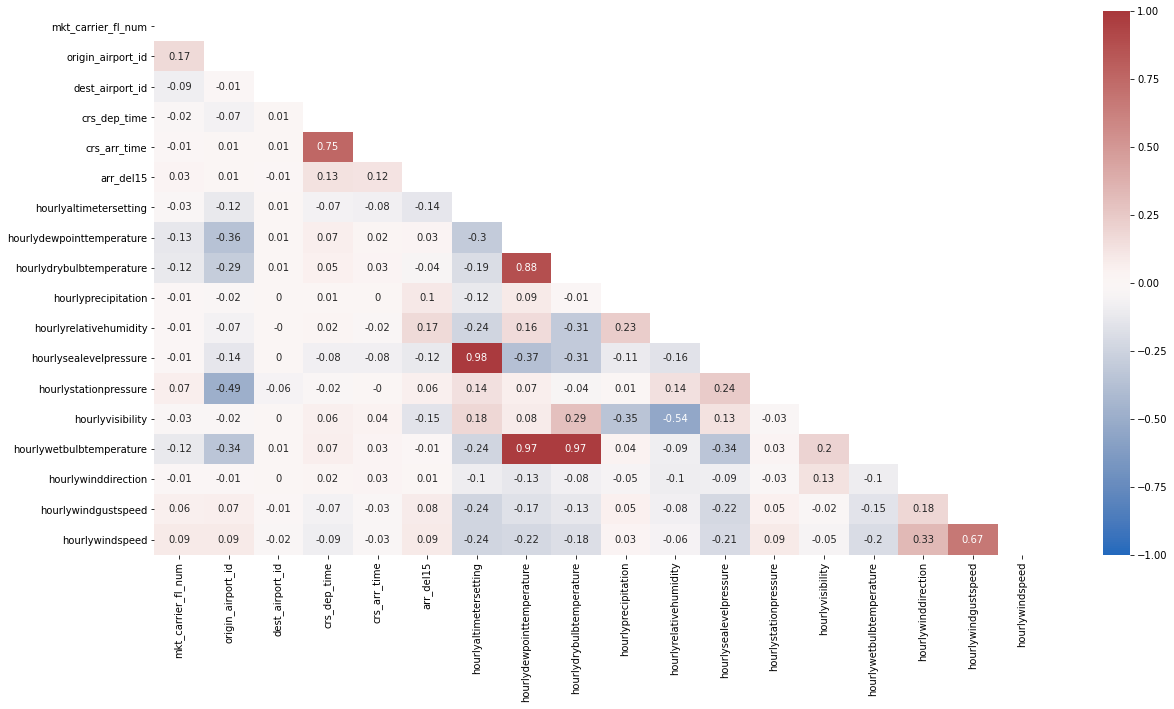

In [19]:
plt.figure(figsize = (20,10))
matrix = dfml.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot = True, vmax = 1, vmin = -1, center =0, cmap='vlag', mask=mask)
plt.savefig('heatmap.png')
plt.show()

## Observations: Correlation Matrix
---

A few features do have a high degree of collinearity, which is not entirely surprising. Some weather measurements are very similar to one another, altimeters are based on air pressure, and arrival times are intuitively correlated to departure times. 

This collinearity will be addressed via PCA. 

# 4. MACHINE LEARNING  

## Train/Test/Split

In [20]:
# train/test/split & scale data
X = dfml.drop(columns = ['arr_del15'])
y = dfml.arr_del15

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Train Models

In [21]:
# Establish baseline performance for the following models:

# Logistic Regression 
log_model = LogisticRegression()
log = log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

# Gradient Boosting Classifier
gbc_model = GradientBoostingClassifier()
gbc = gbc_model.fit(X_train, y_train)
gbc_pred = gbc_model.predict(X_test)

# Random Forest Classifier
rfc_model = RandomForestClassifier()
rfc = rfc_model.fit(X_train, y_train)
rfc_pred = rfc_model.predict(X_test)

# Support Vector Classifier
svc_model = SVC()
svc = svc_model.fit(X_train, y_train)
svc_pred = svc_model.predict(X_test)

## Print Results

In [22]:
log_acc = round(accuracy_score(y_test, log_pred), 3)
gbc_acc = round(accuracy_score(y_test, gbc_pred), 3)
rfc_acc = round(accuracy_score(y_test, rfc_pred), 3)
svc_acc = round(accuracy_score(y_test, svc_pred), 3)

Results = pd.DataFrame({'Logistic Regression': [log_acc],
                        'Gradient Boosting Classifier': [gbc_acc], 
                        'Random Forest': [rfc_acc],   
                        'Suppor Vector Classifer': [svc_acc]},
                        index = ['Accuracy'])
# Add 'Best Score' column
Results['Best Score'] = Results.idxmax(axis=1)

Results

,Logistic Regression,Gradient Boosting Classifier,Random Forest,Suppor Vector Classifer,Best Score
Accuracy,0.614,0.648,0.666,0.649,Random Forest


## Observations
---

With an accuracy score of <b>.666, the Random Forest Classifier performed the best</b> out of all the models and will be the model of focus throughout the remainder of this project. 

Close behind are the Gradient Boosting and Support Vector Classifiers, trailing by roughly 2 percentage points. 

The Logistic Regression model performed the worst with an accuracy score of .614, roughly 5 percentage points behind the Random Forest Classifier. 

# 5. PRINCIPAL COMPONENT ANALYSIS

## Perform PCA

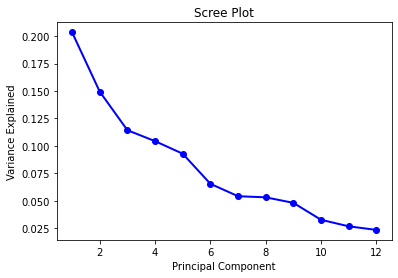

In [23]:
# Configure to keep 95% of the variance. Execute fit_transform to reduce components.
pca = PCA(n_components=.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Print Scree Plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## Retrain Random Forest Classifier

In [24]:
# Random Forest Classifier
rfc_model_pca = RandomForestClassifier()
rfc_pca = rfc_model_pca.fit(X_train_pca, y_train)
rfc_pred_pca = rfc_model_pca.predict(X_test_pca)

## Print Results

In [25]:
rfc_acc_pca = round(accuracy_score(y_test, rfc_pred_pca), 3)

Results_pca = pd.DataFrame({'Random Forest': [rfc_acc],   
                        'With PCA': [rfc_acc_pca],},
                        index = ['Accuracy'])
# Add 'Best Score' column
Results_pca['Best Score'] = Results_pca.idxmax(axis=1)
Results_pca

,Random Forest,With PCA,Best Score
Accuracy,0.666,0.653,Random Forest


## Observations
---

With retaining 95% of the original variance, the number of dimensions in the dataset was reduced to 12, from 17. 

This <b>dimensionality reduction did drop the accuracy score 1.3 percentage points to .653</b>.  
This is not a surprising result as the model had less data to learn from, but the slightly worse accuracy score is likely a worthwhile tradeoff when considering a significantly smaller dataset, especially at scale.

# 6. HYPERPARAMETER TUNING

## Use GridSearch to find optimal parameters

In [26]:
# Parameters
space = dict()
space['max_features'] = ['auto', 'sqrt', 'log2']
space['criterion'] = ['gini', 'entropy']
space['n_estimators'] = [100, 1000, 2000, 2500, 3000]
space['n_jobs'] = [-1]
space['random_state'] = [42]

# Tune and train model
rfc_model_tuning = RandomForestClassifier()
grid_search_rfc = GridSearchCV(estimator=rfc_model_tuning, param_grid=space, scoring= 'accuracy')
grid_search_rfc.fit(X_train, y_train)

# Display best_params_
grid_search_rfc.best_params_

{'criterion': 'entropy',
 'max_features': 'auto',
 'n_estimators': 2500,
 'n_jobs': -1,
 'random_state': 42}

## Train Tuned RFC on Reduced Dataset

In [27]:
rfc_model_tuned_pca = RandomForestClassifier(**grid_search_rfc.best_params_)
rfc_model_tuned_pca.fit(X_train_pca, y_train)
rfc_tuned_pred_pca = rfc_model_tuned_pca.predict(X_test_pca)

## Train Tuned RFC on Original Dataset

In [28]:
rfc_model_tuned = RandomForestClassifier(**grid_search_rfc.best_params_)
rfc_model_tuned.fit(X_train, y_train)
rfc_tuned_pred = rfc_model_tuned.predict(X_test)

## Print Results

In [29]:
rfc_acc_tuned = round(accuracy_score(y_test, rfc_tuned_pred), 3)
rfc_acc_tuned_pca = round(accuracy_score(y_test, rfc_tuned_pred_pca), 3)

Results_tuned = pd.DataFrame({'Random Forest': [rfc_acc],
                              'With PCA': [rfc_acc_pca],
                              'With Tuning': [rfc_acc_tuned],
                              'With PCA & Tuning': [rfc_acc_tuned_pca],},
                           index = ['Accuracy'])

# Add 'Best Score' column
Results_tuned['Best Score'] = Results_tuned.idxmax(axis=1)

Results_tuned

,Random Forest,With PCA,With Tuning,With PCA & Tuning,Best Score
Accuracy,0.666,0.653,0.668,0.657,With Tuning


# 7. CONCLUSION

**Original research question:** How accurately can flight delays be predicted using airline performance data and weather data?

**Conclusion:** Per the results above, a <b>maximum accuracy score of .668, or 66.8%</b> was able to be achieved. This is only moderately better than a coin flip. As most flights are on-time (~85%), pushing this model into production would not provide meaningful value to Delta nor its customers. 

While the full-dimensional model with hyperparameter tuning did achieve the best accuracy score, the 'plain vanilla' model followed closed behind at .666, with the dimensionality-reduced model with hyperparameter tuning coming in third at .657. The worst performing model was the Random Forest Classifier that only had dimensionality reduction performed on it, with an accuracy score of .653. As mentioned earlier in this project, it is no surprise to see the accuracy score be negatively impacted from dimensionality reduction as the model is working with less data. 

All things being considered, very similar accuracy scores were achieved regardless of hyperparameter tuning, dimensionality reduction, or combining the two. I do think the model's accuracy score can be improved, however. Implementing some, or all, of the following may be beneficial: 
* Evaluating more/different classifiers. 
* Increasing the size of the training set. 
* Adding more features. For example, this projectâ€™s dataset only contains weather data for the departing airport. Adding weather data for the arrival airport may improve the model's performance.